# 1. Introduction

## 1.1. Présentation du projet et explication de la démarche


## 1.2. Chargement des packages

In [57]:
import pandas as pd
import geopandas as gpd
import numpy as np

from shapely.geometry import Point
from pynsee.geodata import get_geodata_list, get_geodata, GeoFrDataFrame

from outils import *

from matplotlib import pyplot as plt
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
from io import BytesIO


## 1.3. Chargement des données

### 1.3.1. Données INSEE
On commence par charger la base de données 'données locales' qui contient entre autre
* Le nom des communes française
* Leur population au dernier recensement
* Leur coordonnées géographiques des communes
On s'aide pour cela de la documentation de pynsee (les commandes ici sont utilisable sans clé API)

In [5]:
# On récupère la liste géographique
geodata_list = get_geodata_list()
# On récupère la liste des limites géographique des départements
com = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:commune')

mapcom_raw = gpd.GeoDataFrame(com).set_crs("EPSG:3857")

#Le jeu de données contenant les informations que nous cherchons est le suivant
mapcom_raw.sample(5)

100%|██████████| 99/99 [00:49<00:00,  1.99it/s]


,id,nom,nom_m,insee_com,statut,population,insee_can,insee_arr,insee_dep,insee_reg,siren_epci,geometry,crsCoord
25499,COMMUNE_0000000009740855,Montreuil-sur-Barse,MONTREUIL-SUR-BARSE,10255,Commune simple,288,17,3,10,44,200069250,"MULTIPOLYGON (((481194.898 6142041.483, 481156...",EPSG:3857
18111,COMMUNE_0000000009728651,Rocquigny,ROCQUIGNY,62715,Commune simple,281,09,1,62,32,200035442,"MULTIPOLYGON (((323756.666 6457197.426, 324004...",EPSG:3857
12223,COMMUNE_0000000009742939,Lignières,LIGNIERES,41115,Commune simple,400,09,2,41,24,200040772,"MULTIPOLYGON (((131417.525 6088101.718, 131567...",EPSG:3857
10331,COMMUNE_0000000009761243,Noé,NOE,31399,Commune simple,2949,01,1,31,76,200066819,"MULTIPOLYGON (((141435.338 5371370.492, 141811...",EPSG:3857
23651,COMMUNE_0000000009755469,Saint-Fortunat-sur-Eyrieux,SAINT-FORTUNAT-SUR-EYRIEUX,07237,Commune simple,795,17,2,07,84,200071413,"MULTIPOLYGON (((517426.903 5592879.151, 517893...",EPSG:3857


In [199]:
# Surtout dans les DROM-COM certaines communes apparaissent aussi comme sous-préféctures,par exemple:
mapcom_raw[(mapcom_raw['nom_m'] == 'SAINT-CLAUDE')]


,id,nom,nom_m,insee_com,statut,population,insee_can,insee_arr,insee_dep,insee_reg,siren_epci,geometry,crsCoord
6,COMMUNE_0000001169858685,Saint-Claude,SAINT-CLAUDE,97124,Commune simple,10700,06,1,971,01,249710070,"MULTIPOLYGON (((-6869802.488 1804329.757, -687...",EPSG:3857
27957,COMMUNE_0000000009749074,Saint-Claude,SAINT-CLAUDE,39478,Sous-préfecture,8727,14,3,39,27,200026573,"MULTIPOLYGON (((648695.631 5837666.044, 648666...",EPSG:3857


In [6]:
# Ainsi, certaines communes apparaisent en double en tant que sous-préféctures, on ne garde ici que les communes

# On identifie les doublons dans la colonne 'nom_m'
duplicates = mapcom_raw[mapcom_raw['nom_m'].duplicated(keep=False)]

# On sélectionne les lignes où 'statut' est égal à 'Commune simple'
simple_communes = duplicates[duplicates['statut'] == 'Commune simple']

# On conserve les lignes avec des 'nom_m' uniques ou celles avec 'Commune simple' lorsque des doublons existent
mapcom = pd.concat([
    mapcom_raw[~mapcom_raw['nom_m'].duplicated(keep=False)],  # Lignes sans doublons
    simple_communes  # Lignes où 'Commune simple' est sélectionné
]).drop_duplicates(subset='nom_m', keep='first')  # S'assurer que 'nom_m' est unique dans le résultat final

# Réinitialiser l'index pour plus de clarté 
mapcom.reset_index(drop=True, inplace=True)

# Afficher le DataFrame final
mapcom.sample(5)


,id,nom,nom_m,insee_com,statut,population,insee_can,insee_arr,insee_dep,insee_reg,siren_epci,geometry,crsCoord
22584,COMMUNE_0000000009742187,Bagneux-la-Fosse,BAGNEUX-LA-FOSSE,10025,Commune simple,173,08,3,10,44,200069003,"MULTIPOLYGON (((472111.684 6107892.634, 472145...",EPSG:3857
12927,COMMUNE_0000000009757667,Sanvensa,SANVENSA,12259,Commune simple,643,02,3,12,76,200069383,"MULTIPOLYGON (((232106.099 5511870.599, 232088...",EPSG:3857
22597,COMMUNE_0000000009743891,Origny,ORIGNY,21470,Commune simple,52,05,3,21,27,242101434,"MULTIPOLYGON (((514176.422 6057337.142, 514214...",EPSG:3857
5752,COMMUNE_0000000009761778,Moulédous,MOULEDOUS,65324,Commune simple,215,14,3,65,76,200070803,"MULTIPOLYGON (((22488.309 5346729.814, 22520.8...",EPSG:3857
3459,COMMUNE_0000000009756543,Gironde-sur-Dropt,GIRONDE-SUR-DROPT,33187,Commune simple,1311,27,3,33,75,200044394,"MULTIPOLYGON (((-9600.595 5554587.333, -9929.7...",EPSG:3857


### 1.3.2. Données Géod'air

Les données Géod'air sont un jeu de données issue de Géod'air le pourvoyeur public de données sur la pollution atmosphériques. Elles consistent en des jeux de données .csv tékéchargées préalablements représentant la mesure de 5 polluants différents et des informations conjointes (nom et lieux des sites de meusures, types de mesures, etc.) regroupés par intervalles de 6 mois entre le 1er janvier 2020 et le 31 décembre 2023.
On compte donc au total 40 fichiers .csv.

**Remarque :** Pour obtenir les données une API existe, cependant celle ci ne permet que d'obtenir des données par intervals de 1 jour, afin de gagner du temps dans les requêtes et pour ne pas risquer de surcharger les serveurs de Géod'air nous avons préféré utiliser leur outil de chargement sur-mesure des données

In [7]:
folder_paths = [
   r"CSV_data\GEODAIR\NO2\NO2_moy_hor_per", #Utiliser soit r"..." soit des \\ sinon les "\N" de "\NO2" posent problème
    "CSV_data\GEODAIR\O3\O3_moy_hor_per",
    "CSV_data\GEODAIR\PM2.5\PM2.5_moy_jour_per",
    "CSV_data\GEODAIR\PM10\PM10_moy_jour_per",
    "CSV_data\GEODAIR\SO2\SO2_moy_hor_per"
    ]

#Ici l'instruction "range(8,1,-1)" permet de classer les chemins du plus récent au moins récent.
all_file_paths = [[ folder + str(i) + ".csv" for i in range(8,0,-1)] for folder in folder_paths]

# On combine les 40 (5x8) jeux de données en 5 dataframes allant de janvier 2020 à décembre 2023
# Pour les polluants dans l'ordre suivant: NO2, O3, PM2.5, PM10, SO2
all_combined_df = [pd.concat([pd.read_csv(file, sep = ";") for file in all_file_paths[i]]) for i in range(5)]

#On obtien une liste de 5 dataframes, soit un par polluant

In [8]:
# On souhaite avoir un jeu de données pour lesquels seuls les mesures ayant mesuré tous les polluants sont conservés
# On précise les colonnes sur lesquels on applique la jonction
join_columns = ["Date de début", "Date de fin", "code site"]

# On sélectionne le data frame avec le plus petit nombre de lignes
smallest_df = min(all_combined_df, key=len)

# On initialise avec les plus petit data frame
result_df = smallest_df

# On joint chaque dataframe de notre liste "all_combined_df" avec un suffixe unique
for i, df in enumerate(all_combined_df):
    if df is not smallest_df:  # pour éviter l'auto-jonction
        result_df = pd.merge(
            result_df, 
            df, 
            on=join_columns, 
            how='inner', 
            suffixes=(None, f'_df{i}')  # Un suffixe unique pour chaque data frame
        )

# result_df contient maintenant le inner join of de tous les data frames sur les colonnes spécifées
# On obtient un objet qui contient beaucoup plus de variable que ce qui nous intéresse, on vien donc procéder à un premier tri

# Soit la liste des variables les plus utiles, on peut l'utiliser pour extraire un version synthétique du de result_df
best_variables = [
    'Date de début', 'Date de fin', 'Organisme', 'code zas', 'Zas', 'code site', 'nom site', "type d'implantation", 'Latitude', 'Longitude',
    'Polluant', "type d'influence", 'type de valeur', 'valeur', 'valeur brute', 'unité de mesure','code qualité', 'validité',
    'Polluant_df0', 'type de valeur_df0', 'valeur_df0', 'valeur brute_df0', 'unité de mesure_df0','code qualité_df0', 'validité_df0',
    'Polluant_df1', 'type de valeur_df1', 'valeur_df1', 'valeur brute_df1', 'unité de mesure_df1','code qualité_df1', 'validité_df1',
    'Polluant_df2', 'type de valeur_df2', 'valeur_df2', 'valeur brute_df2', 'unité de mesure_df2','code qualité_df2', 'validité_df2',
    'Polluant_df3', 'type de valeur_df3', 'valeur_df3', 'valeur brute_df3', 'unité de mesure_df3','code qualité_df3', 'validité_df3',
]

best_df = result_df[best_variables]

# Etape cosmétique pour faciliter la lecture des données intermédiaires
# On définit une fonction pour renommer les colonnes
# Définir les colonnes qui doivent garder leur nom tel quel
columns_to_keep = [
    'Date de début', 'Date de fin', 'Organisme', 'code zas', 'Zas', 
    'code site', 'nom site', "type d'implantation", 'Latitude', 'Longitude'
]

# Définir la fonction pour renommer les colonnes
def rename_columns(column_name):
    # Vérifier si la colonne doit conserver son nom
    if column_name in columns_to_keep:
        return column_name
    # Ajouter le suffixe "_SO2" pour les colonnes sans suffixe qui ne sont pas dans columns_to_keep
    elif not any(column_name.endswith(suffixe) for suffixe in ["_df0", "_df1", "_df2", "_df3"]):
        return f"{column_name}_SO2"
    # Remplacer les suffixes spécifiques
    elif column_name.endswith("_df0"):
        return column_name.replace("_df0", "_NO2")
    elif column_name.endswith("_df1"):
        return column_name.replace("_df1", "_O3")
    elif column_name.endswith("_df2"):
        return column_name.replace("_df2", "_PM2.5")
    elif column_name.endswith("_df3"):
        return column_name.replace("_df3", "_PM10")
    else:
        return column_name

best_df = best_df.rename(columns=rename_columns)


# Pour l'instant les données ne sont pas dans un format géographique, on transforme donc le dataframe en GeoDataFrame
best_dfgeo = gpd.GeoDataFrame(
    best_df, geometry=gpd.points_from_xy(best_df.Longitude, best_df.Latitude)
)

# Une visualisation des données donne donc:
best_dfgeo.sample(5)

,Date de début,Date de fin,Organisme,code zas,Zas,code site,nom site,type d'implantation,Latitude,Longitude,...,code qualité_PM2.5,validité_PM2.5,Polluant_PM10,type de valeur_PM10,valeur_PM10,valeur brute_PM10,unité de mesure_PM10,code qualité_PM10,validité_PM10,geometry
12870,2021/11/27 00:00:00,2021/11/27 23:59:59,ATMO NORMANDIE,FR28ZAR01,ZAR LE-HAVRE,FR05090,Le Havre ville-haute,Urbaine,49.514686,0.100645,...,A,1,PM10,Moy. journalière,13.0,12.641667,µg-m3,A,1,POINT (0.10064 49.51469)
13307,2021/12/27 00:00:00,2021/12/27 23:59:59,ATMO GRAND EST,FR44ZRE01,ZR GRAND-EST,FR30033,Jonville en Woevre,Rurale régionale,49.065830,5.785556,...,A,1,PM10,Moy. journalière,9.0,9.445833,µg-m3,A,1,POINT (5.78556 49.06583)
4602,2023/05/08 00:00:00,2023/05/08 23:59:59,ATMO HAUTS DE FRANCE,FR32ZRE01,ZR HAUTS-DE-FRANCE,FR18042,P. Roth St Quentin,Urbaine,49.851334,3.284000,...,A,1,PM10,Moy. journalière,9.0,9.308333,µg-m3,A,1,POINT (3.284 49.85133)
5628,2022/07/10 00:00:00,2022/07/10 23:59:59,ATMO REUNION,FR04ZAR01,ZAR SAINT-DENIS,FR38020,Plateau Caillou,Urbaine,-21.022112,55.266773,...,A,1,PM10,Moy. journalière,10.0,10.075000,µg-m3,A,1,POINT (55.26677 -21.02211)
8543,2022/02/01 00:00:00,2022/02/01 23:59:59,ATMO REUNION,FR04ZAR01,ZAR SAINT-DENIS,FR38020,Plateau Caillou,Urbaine,-21.022112,55.266773,...,N,-1,PM10,Moy. journalière,19.0,18.712500,µg-m3,N,-1,POINT (55.26677 -21.02211)


In [8]:
#On revient maintenant à notre liste de dataframe, afin de pouvoir identifier les communes au sein desquelles les mesures ont été faites
#Pour rappel, on a tous les df dans la liste all_combined_df
result = []
result_simple = []
result_simple_agg = []
geometries = []
variable_gdf = []

# On séléctionne les variables les plus intéréssantes pour le projet 
variable_interet = ['Date de fin',
                    "type d'implantation",
                    "type d'influence", 
                    'valeur', 
                    'geometry',
                    'index_right', 
                    'id', 
                    'nom', 
                    'nom_m', 
                    'insee_com', 
                    'statut',
                    'population', 
                    'insee_can', 
                    'insee_arr', 
                    'insee_dep', 
                    'insee_reg',
                    'siren_epci', 
                    'crsCoord'
                    ]

for indice_polluant in range(5):
    gdf = gpd.GeoDataFrame(all_combined_df[indice_polluant], geometry=gpd.points_from_xy(all_combined_df[indice_polluant].Longitude, all_combined_df[indice_polluant].Latitude)).set_crs('EPSG:4326') #EPSG:4326 est le CRS correspondant aux longitudes-latitudes
    #On projette mapcom les données dans le même CRS
    mapcom = mapcom.to_crs(gdf.crs) 
    #Jonction spatiale, l'argument within identifie les coordonnées qui sont au sein des géométries des communes
    result.append(gpd.sjoin(gdf, mapcom, how="left", predicate="within"))
    # Cette étape permet de formater les dates au format datetime
    result[indice_polluant]['Date de fin'] = result[indice_polluant]['Date de fin'].apply(format_date)

    result_simple.append(result[indice_polluant][variable_interet])

    #On va maintenant grouper les mesures par commune et par jour pour alléger le jeu de données
    result_simple_agg.append(result_simple[indice_polluant].groupby(['nom_m', 'Date de fin'], as_index=False).agg({'valeur': 'mean'}))
    
    # On ajoute ici une géométrie en reprenant la première géométrie de chaque groupe
    geometries.append(result_simple[indice_polluant].groupby(['nom_m', 'Date de fin'])['geometry'].first().reset_index())
    
    # On fusionne pour réassocier la géométrie
    variable_gdf.append(gpd.GeoDataFrame(result_simple_agg[indice_polluant].merge(geometries[indice_polluant],on=['nom_m', 'Date de fin']),geometry='geometry', crs=result_simple[indice_polluant].crs))
    
    # On renomme 'Date de fin' en un plus simple 'date'
    variable_gdf[indice_polluant].rename(columns = {'Date de fin' : 'date'}, inplace = True)

# On obtient pour chaque polluant un GéoDataFrame ayant les données suivantes: 
# nom de la commune en majuscule ('nom_m')
# date au format datetime ('date')
# La valeur moyenne des mesures de pulluants ce jour là et à cette date là ('valeur')
# Les coordonnées sous forme d'un objet POINT ('geometry')
variable_gdf[4].sample(5)

#Remarque : cette cellule peut prendre du temps à s'effectuer

,nom_m,date,valeur,geometry
19094,FEYZIN,2022-04-13,42.4,POINT (4.8459 45.6639)
86098,SAINTE-ADRESSE,2023-05-15,2.3,POINT (0.08461 49.50386)
64278,PAIMBŒUF,2021-10-01,2.2,POINT (-2.03229 47.28611)
12703,CHATENOIS,2020-08-03,7.9,POINT (5.55612 47.14725)
30494,HARFLEUR,2021-01-17,1.3,POINT (0.20169 49.505)


In [9]:
# Enfin, on vient fusionner les 5 dataframe en un (outer join car on veut conserver le plus d'information possible)
all_variable_gdf1 = pd.merge(variable_gdf[0],variable_gdf[1], how='outer', on =['nom_m','date','geometry'], validate='1:1', suffixes = ('_NO2','_O3'))
all_variable_gdf2 = pd.merge(variable_gdf[2],variable_gdf[3], how='outer', on =['nom_m','date','geometry'], validate='1:1', suffixes = ('_PM2.5','_PM10'))
all_variable_gdf2 = pd.merge(all_variable_gdf2,variable_gdf[4], how='outer', on =['nom_m','date','geometry'], validate='1:1', suffixes = (False,'_SO2'))
all_variable_gdf = pd.merge(all_variable_gdf1,all_variable_gdf2, how='outer', on =['nom_m','date','geometry'], validate='1:1', suffixes = (False,False))
mapcom_simple = mapcom[['id', 'nom_m', 'insee_com', 'statut', 'population', 'insee_dep']]
all_variable_gdf = pd.merge(all_variable_gdf, mapcom_simple, how = 'left', on = 'nom_m', validate = 'm:1',suffixes = (False,False))


#Etape cosmétique pour faciliter la lisibilité (on fait apparaître le nom de chaque polluant)
all_variable_gdf.rename(columns = {
    'valeur_NO2': 'NO2',
    'valeur_O3': 'O3',
    'valeur_PM2.5': 'PM2.5',
    'valeur_PM10':'PM10',
    'valeur' : 'SO2'}, inplace = True)


In [10]:
# On vient éliminer certains duplicatats issus d'irrégularités au sein de la variable geometry
grouping_columns = all_variable_gdf.drop(columns=['NO2', 'O3', 'PM2.5', 'PM10', 'SO2','geometry']).columns
#On enlève la colonne geometry car celle ci comporte des doublons à un 100 000ième de coordonnée près
polluants_gdf = all_variable_gdf.groupby(list(grouping_columns), as_index=False).agg({
    'NO2': 'max',
    'O3': 'max',
    'PM2.5': 'max',
    'PM10': 'max',
    'SO2': 'max'
})

#On rajoute la colonne geometry en ne conservant qu'une seulle valeur pour chaque ville
geometries = all_variable_gdf[['nom_m','geometry']].drop_duplicates(subset='nom_m')

polluants_gdf = gpd.GeoDataFrame(pd.merge(polluants_gdf,geometries, how = 'left', on= 'nom_m'),geometry='geometry', crs='EPSG:4326')

In [11]:
polluants_gdf

,nom_m,date,id,insee_com,statut,population,insee_dep,NO2,O3,PM2.5,PM10,SO2,geometry
0,AGDE,2020-01-01,COMMUNE_0000000009761167,34003,Commune simple,29103,34,23.2,53.4,NaN,NaN,NaN,POINT (3.50484 43.2875)
1,AGDE,2020-01-02,COMMUNE_0000000009761167,34003,Commune simple,29103,34,32.8,33.9,NaN,NaN,NaN,POINT (3.50484 43.2875)
2,AGDE,2020-01-03,COMMUNE_0000000009761167,34003,Commune simple,29103,34,24.6,55.1,NaN,NaN,NaN,POINT (3.50484 43.2875)
3,AGDE,2020-01-04,COMMUNE_0000000009761167,34003,Commune simple,29103,34,11.4,67.2,NaN,NaN,NaN,POINT (3.50484 43.2875)
4,AGDE,2020-01-05,COMMUNE_0000000009761167,34003,Commune simple,29103,34,26.7,67.8,NaN,NaN,NaN,POINT (3.50484 43.2875)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
560652,XONRUPT-LONGEMER,2023-12-27,COMMUNE_0000000009741120,88531,Commune simple,1488,88,1.7,77.8,NaN,NaN,NaN,POINT (7.01111 48.05112)
560653,XONRUPT-LONGEMER,2023-12-28,COMMUNE_0000000009741120,88531,Commune simple,1488,88,1.7,73.2,NaN,NaN,NaN,POINT (7.01111 48.05112)
560654,XONRUPT-LONGEMER,2023-12-29,COMMUNE_0000000009741120,88531,Commune simple,1488,88,1.4,71.8,NaN,NaN,NaN,POINT (7.01111 48.05112)
560655,XONRUPT-LONGEMER,2023-12-30,COMMUNE_0000000009741120,88531,Commune simple,1488,88,0.8,74.4,NaN,NaN,NaN,POINT (7.01111 48.05112)


### 1.3.3. Données MétéoFrance

In [12]:
# On charge d'abord les données de mesure depuis l'environnement local (comme pour Géod'air)
path = 'CSV_data\METEOFRANCE'
df_meteo_month = []

for year in range(2020, 2024):  
    for month in range(1, 13):  
        date = f"{year}{month:02d}"  # Format "202001", "202002", etc
        file_name = f"synop.{date}.csv.gz"
        file_path = os.path.join(path, file_name)
        try:
            df = pd.read_csv(file_path, compression='gzip', sep=';', encoding='utf-8')
            df_meteo_month.append(df)  # Ajouter chaque DataFrame à la liste
        except FileNotFoundError:
            print(f"Fichier non trouvé : {file_path}")
        except Exception as e:
            print(f"Erreur lors du chargement de {file_path} : {e}")

df_meteo = pd.concat(df_meteo_month, ignore_index=True)

# Etape cosmétique pour ne garder que les variables d'intérêt et simplifier la lecture
colonnes_a_garder = ['numer_sta', 'date', 'pmer', 'tend', 'dd', 'ff', 't', 'u', 'vv', 'rr24']
noms_colonnes = {
    'numer_sta': 'ID',
    'pmer': 'pression_niveau_mer_Pa',
    'tend': 'var_pression_3h_Pa',
    'dd': 'direction_vent_moyen_10mn_deg',
    'ff': 'vitesse_vent_moyen_10mn_m/s',
    't': 'temperature_K',
    'u': 'humidite_%',
    'vv': 'visibilite_horizontale_m',
    'rr24': 'precipitations_24h_mm'
}

def filtre_mesure_minuit(df):
    # Convertir la colonne date au format datetime
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H%M%S', errors='coerce')
    
    # Filtrer les lignes correspondant à minuit (heure, minute et seconde égales à 0)
    df_minuit = df[(df['date'].dt.hour == 0) & 
                   (df['date'].dt.minute == 0) & 
                   (df['date'].dt.second == 0)]
    
    return df_minuit


df_meteo = df_meteo[colonnes_a_garder]
df_meteo = df_meteo.rename(columns=noms_colonnes)
df_meteo = filtre_mesure_minuit(df_meteo)  # Garder seulement les mesures à minuit
df_meteo['date'] = df_meteo['date'].dt.strftime('%Y-%m-%d')

df_meteo.sample(5)

,ID,date,pression_niveau_mer_Pa,var_pression_3h_Pa,direction_vent_moyen_10mn_deg,vitesse_vent_moyen_10mn_m/s,temperature_K,humidite_%,visibilite_horizontale_m,precipitations_24h_mm
598189,7255,2023-06-13,101000,-140,340,1.200000,292.350000,86,20000,-0.100000
310388,7130,2021-10-15,102110,-110,280,0.900000,278.950000,99,670,-0.100000
315198,7434,2021-10-25,102300,20,40,0.900000,280.750000,94,740,0.000000
330684,7299,2021-11-28,99790,-20,150,2.100000,273.750000,90,23000,mq
356119,7181,2022-01-22,103640,-40,260,1.600000,274.950000,96,6980,-0.100000


In [13]:
# On extrait les données des stations de mesure et on les joint à notre dataframe df_meteo
stations_gdf = gpd.read_file('CSV_data\METEOFRANCE\postesSynop.json')
stations_gdf['Longitude'] = stations_gdf['Longitude'].astype(float)
stations_gdf['Latitude'] = stations_gdf['Latitude'].astype(float)
stations_gdf['ID'] = stations_gdf['ID'].astype(int)

stations_gdf.sample(5)

,ID,Nom,Latitude,Longitude,Altitude,geometry
51,71805,ST-PIERRE,46.766333,-56.179167,21,POINT (-56.17917 46.76633)
16,7240,TOURS,47.444500,0.727333,108,POINT (0.72733 47.4445)
60,81415,MARIPASOULA,3.640167,-54.028333,106,POINT (-54.02833 3.64017)
50,67005,PAMANDZI,-12.805500,45.282833,7,POINT (45.28283 -12.8055)
42,61968,GLORIEUSES,-11.582667,47.289667,3,POINT (47.28967 -11.58267)


In [14]:
meteo_gdf = gpd.GeoDataFrame(
    pd.merge(df_meteo,stations_gdf, how = 'left', on='ID', validate = 'm:m', suffixes = (False,False)),
    geometry='geometry')

meteo_gdf.sample(5)
#On a vérifié qu'il n'y avait pas d'errerus d'appairement

,ID,date,pression_niveau_mer_Pa,var_pression_3h_Pa,direction_vent_moyen_10mn_deg,vitesse_vent_moyen_10mn_m/s,temperature_K,humidite_%,visibilite_horizontale_m,precipitations_24h_mm,Nom,Latitude,Longitude,Altitude,geometry
85652,7434,2023-12-13,100630,-130,240,3.800000,282.050000,94,48760,5.200000,LIMOGES-BELLEGARDE,45.861167,1.175000,402,POINT (1.175 45.86117)
13620,7690,2020-08-17,101110,-70,330,3.000000,296.750000,74,30000,0.000000,NICE,43.648833,7.209000,2,POINT (7.209 43.64883)
81991,7005,2023-10-13,101230,-180,150,1.600000,290.350000,96,11930,2.000000,ABBEVILLE,50.136000,1.834000,69,POINT (1.834 50.136)
63485,7299,2022-12-09,100770,-130,340,2.500000,271.750000,100,1560,0.000000,BALE-MULHOUSE,47.614333,7.510000,263,POINT (7.51 47.61433)
13359,7240,2020-08-13,101250,40,140,3.200000,295.450000,87,29600,0.600000,TOURS,47.444500,0.727333,108,POINT (0.72733 47.4445)


### 1.3.4. Données ADEME

Ce jeu de données est *l'inventaire de gaz à effet de serre territorialisé* de l'ADEME.
Il s'agit du résultat de l'inventaire national de gaz à effet de serre (GES).
D'après l'ADEME : *"La résolution spatiale est communale, structures stables dans le temps et ensuite agrégeables par EPCI. Il est établi à partir à la fois à partir d’une décomposition des émissions nationales de GES au niveau communal et d’informations déjà spatialisées."*

In [15]:
#La première étape est une importation classique avec pandas
inventaire_ges = pd.read_csv("https://data.ademe.fr/data-fair/api/v1/datasets/igt-pouvoir-de-rechauffement-global/full")

#On fait apparaître la collonne des totaux et log-totaux (La distribution des totaux suit une loi log-normale)
inventaire_ges['total'] = inventaire_ges.drop(['INSEE commune', 'Commune','lat','lon'], axis = 1).sum(numeric_only=True, axis = 1)
inventaire_ges['total'] = inventaire_ges['total'].fillna(inventaire_ges['total'].mean(numeric_only=True, axis = 0))
inventaire_ges['log_total'] = np.log(inventaire_ges['total'])

#On spatialise le DataFrame à l'aide du jeu de donnée de l'INSEE
#Pour la compatibilité avec l'INSEE
inventaire_ges = inventaire_ges.rename(columns={'Commune':'nom_m'})
ademe_gdf = gpd.GeoDataFrame(
    pd.merge(inventaire_ges,mapcom, how = 'left', on = 'nom_m', validate='m:m', suffixes=(False,False)),
    geometry='geometry'
)

ademe_gdf.sample(5)

,INSEE commune,nom_m,Agriculture,Autres transports,Autres transports international,CO2 biomasse hors-total,Déchets,Energie,Industrie hors-énergie,Résidentiel,...,insee_com,statut,population,insee_can,insee_arr,insee_dep,insee_reg,siren_epci,geometry,crsCoord
9748,27149,LA CHAPELLE-HARENG,814.336416,NaN,NaN,81.717056,11.505152,7.063673,20.733640,38.339562,...,27149,Commune simple,124.0,03,2,27,28,200066017,"MULTIPOLYGON (((0.40941 49.12088, 0.40972 49.1...",EPSG:3857
9958,27393,MARTAINVILLE,2953.201254,NaN,NaN,312.103079,2197.823110,2.354558,6.911213,184.092361,...,14404,Commune simple,123.0,22,2,14,28,200066710,"MULTIPOLYGON (((-0.34861 48.9257, -0.35048 48....",EPSG:3857
15597,40124,HERRE,1229.003983,NaN,NaN,133.265907,16.927120,2.354558,6.911213,55.883610,...,40124,Commune simple,140.0,08,2,40,75,200035541,"MULTIPOLYGON (((-0.00032 44.03912, -0.00007 44...",EPSG:3857
12523,32324,PONSAN-SOUBIRAN,1042.665477,NaN,NaN,103.381828,14.546744,2.354558,6.911213,54.992807,...,32324,Commune simple,76.0,03,3,32,76,200072320,"MULTIPOLYGON (((0.47982 43.3326, 0.47945 43.33...",EPSG:3857
33680,85204,SAINT-CHRISTOPHE-DU-LIGNERON,9535.621479,NaN,NaN,2015.832253,21224.757785,209.555639,615.097988,1357.003257,...,85204,Commune simple,2632.0,02,3,85,52,200071629,"MULTIPOLYGON (((-1.78204 46.78116, -1.7817 46....",EPSG:3857


## 1.4. Jonction Geod'air-MétéoFrance

Dans cette partie on va procéder à la jonction entre les jeux de donnée Géod'air et météofrance. Ici un simple Merge ou un sjoin ne suffisent pas car nous ne pouvons pas assumer priori qu'il y ait une station de mesure météofrance pour chaque station de mesure utilisée par Géod'air (il y a a priori plus de stations de mesure Géod'air). L'idée est donc d'attacher à chaque mesure de polluant la mesure météofrance du même jour de la station la plus proche.

In [16]:

# On s'assure que les deux GeoDataFrames utilisent le même système de coordonnées
polluants_gdf = polluants_gdf.to_crs("EPSG:4326")
meteo_gdf = meteo_gdf.to_crs("EPSG:4326")
stations_gdf = stations_gdf.to_crs("EPSG:4326")

# On joint d'abord les mesures de polluants avec leur station météofrance la plus proche
polluants_stations_gdf = gpd.sjoin_nearest(
    polluants_gdf,
    stations_gdf,
    how = 'left',
    distance_col="distance_p2m", 
    exclusive=True
    ).to_crs("EPSG:4326").drop(columns = ['id','Nom','index_right'],inplace = False)

# Puis on combine le DataFrame intermédiaire obtenu avec le DataFrame MétéoFrance
processus_gdf = gpd.GeoDataFrame(
    pd.merge(polluants_stations_gdf,df_meteo, how='left', on=['date','ID'], suffixes = (False,False)).reset_index(),
    geometry='geometry'
).reset_index()
processus_gdf.sample(5)

c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,level_0,index,nom_m,date,insee_com,statut,population,insee_dep,NO2,O3,...,Altitude,distance_p2m,pression_niveau_mer_Pa,var_pression_3h_Pa,direction_vent_moyen_10mn_deg,vitesse_vent_moyen_10mn_m/s,temperature_K,humidite_%,visibilite_horizontale_m,precipitations_24h_mm
248763,248763,248763,LE LAMENTIN,2022-03-03,97213,Commune simple,39641,972,16.8,58.8,...,3,0.016810,101480,100,80,3.000000,297.950000,89,52920,2.200000
206429,206429,206429,HARFLEUR,2021-03-03,76341,Commune simple,8315,76,NaN,NaN,...,67,0.733762,102840,20,140,3.200000,279.750000,83,16430,0.000000
120764,120764,120764,CHANCEAUX-SUR-CHOISILLE,2022-05-11,37054,Commune simple,3519,37,NaN,98.6,...,108,0.026694,101620,-80,230,1.500000,288.250000,69,34880,0.000000
392778,392778,392778,PORNICHET,2022-08-05,44132,Commune simple,12121,44,NaN,94.8,...,26,0.730539,101800,80,360,3.200000,291.150000,70,60000,0.400000
382956,382956,382956,PERPIGNAN,2023-07-22,66136,Préfecture,119656,66,28.4,93.4,...,42,0.061816,101590,30,300,5.100000,297.050000,48,60000,0.000000


# 2. Analyse exploratoire de données

# 3. Modélisation des séries temporelles

## 3.1. Explications

## 3.2. Préparation des données

In [17]:
# Enregistrement des convertisseurs pour éviter les avertissements
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)



One sélectionne les variables d'intérêt, c'est-à-dire les variables stochastiques numériques et les clées de ces variables.

In [108]:
processus_gdf.columns

Index(['level_0', 'index', 'nom_m', 'date', 'NO2', 'geometry', 'O3', 'PM2.5',
       'PM10', 'SO2', 'insee_com', 'statut', 'population', 'insee_dep', 'ID',
       'Latitude', 'Longitude', 'Altitude', 'distance_p2m',
       'pression_niveau_mer_Pa', 'var_pression_3h_Pa',
       'direction_vent_moyen_10mn_deg', 'vitesse_vent_moyen_10mn_m/s',
       'temperature_K', 'humidite_%', 'visibilite_horizontale_m',
       'precipitations_24h_mm'],
      dtype='object')

In [ ]:
X_t = processus_gdf.loc[:,[
    'date',
    'nom_m',
    'pression_niveau_mer_Pa',
    'var_pression_3h_Pa',
    'direction_vent_moyen_10mn_deg',
    'vitesse_vent_moyen_10mn_m/s',
    'temperature_K',
    'humidite_%',
    'visibilite_horizontale_m',
    'precipitations_24h_mm'
    ]].reset_index()

X_t.replace('mq', np.nan, inplace=True)

X_t = X_t.astype({
    'pression_niveau_mer_Pa' : 'float',
    'var_pression_3h_Pa' : 'float',
    'direction_vent_moyen_10mn_deg' : 'float',
    'vitesse_vent_moyen_10mn_m/s' : 'float',
    'temperature_K' : 'float',
    'humidite_%' : 'float',
    'visibilite_horizontale_m' : 'float',
    'precipitations_24h_mm'  : 'float'
})

X_t['date'] = pd.to_datetime(X_t['date'], errors='coerce')

X_t.sample(5)

,index,date,nom_m,pression_niveau_mer_Pa,var_pression_3h_Pa,direction_vent_moyen_10mn_deg,vitesse_vent_moyen_10mn_m/s,temperature_K,humidite_%,visibilite_horizontale_m,precipitations_24h_mm
35397,35397,2021-08-30,AYTRE,101890.0,-10.0,50.0,7.7,291.15,68.0,16000.0,0.0
87839,87839,2022-11-22,BRIVE-LA-GAILLARDE,100640.0,100.0,210.0,2.3,278.35,96.0,13180.0,13.7
113609,113609,2022-09-15,CHAMBERY,101110.0,70.0,130.0,0.8,290.45,90.0,40000.0,16.3
323316,323316,2020-02-18,MONTANDON,102880.0,140.0,210.0,3.1,278.55,83.0,60000.0,4.8
302111,302111,2022-10-06,MARIGNY-LES-USAGES,102780.0,270.0,290.0,3.8,287.35,78.0,25000.0,0.4


In [144]:
Y_t = processus_gdf.loc[:,[
    'date',
    'nom_m',
    'NO2',
    'O3',
    'PM2.5',
    'PM10',
    'SO2',
    'population'
    ]].reset_index()

Y_t.replace('NaN', np.nan, inplace=True,)

Y_t['date'] = pd.to_datetime(X_t['date'], errors='coerce')

Y_t.dtypes
# Y_t = processus_gdf[['date','nom_m','NO2','O3','PM2.5','PM10']]

index                  int64
date          datetime64[ns]
nom_m                 object
NO2                  float64
O3                   float64
PM2.5                float64
PM10                 float64
SO2                  float64
population             int64
dtype: object

## 3.3 Modélisation

On cherche d'abord à savoir à quoi une série temporelle peut ressembler, on a donc prendre un premier exemple avec Strasbourg.

In [141]:
import warnings

def eval_model(endog, exog = None, P = 3, Q = 3, D = 3):
  '''Une fonction pour évaluer les modèles SARIMAX'''

  models = pd.DataFrame(np.zeros((D,2), dtype=float), columns = ['AIC','Model'])
  warnings.simplefilter('ignore')
  # Itération des modèles ARMA(p,q,r)
  for d in range(D):
    aic = pd.DataFrame(np.zeros((P,Q), dtype=float))
    aic.iloc[0,0] = np.nan
    for p in range(P):
      for q in range(Q):
        if p == 0 and q == 0:
          continue

        # Estimation de chaque model
        mod = sm.tsa.statespace.SARIMAX(endog,exog, order=(p,d,q), enforce_invertibility=False)
        try:
          res = mod.fit(disp=False)
          # On choisit le critère d'information bayesien pour pénaliser plus la complexité des modèles
          aic.iloc[p,q] = res.bic
        except:
          aic.iloc[p,q] = np.nan

        models['AIC'][d] = aic.min().min()
        coord_min = aic.stack().idxmin()
        models['Model'][d] = str(coord_min[0])+str(d) + str(coord_min[1])
  return models

def select_model(endog, exog, P = 3, Q = 3, D = 3):
  '''Une fonction pour sélectionner le meilleur modèle SARIMAX'''
  df_eval = eval_model(endog, exog,P,Q,D)
  best_model = df_eval['Model'][df_eval['AIC'].idxmin()]
  return best_model

# Ces fonctions sont optimisées grâce à ChatGPT, la différence en terme de rapidité d'exécution n'est pas très impressionnante (0.4 sec pour Perpignan)
from itertools import product
def eval_model_optimized(endog, exog=None, P=3, Q=3, D=3):
    """
    Evaluate SARIMAX models with optimized looping and memory usage.
    """
    warnings.simplefilter("ignore")
    
    # Prepare grid of parameters
    param_grid = list(product(range(P), range(D), range(Q)))
    results = []

    for p, d, q in param_grid:
        if p == 0 and q == 0:
            results.append((np.nan, f"{p}{d}{q}"))

        try:
            # Fit SARIMAX model
            mod = sm.tsa.statespace.SARIMAX(endog, exog, order=(p, d, q), enforce_invertibility=False)
            res = mod.fit(disp=False)

            # Store results
            results.append((res.bic, f"{p}{d}{q}"))
        except:
            # If the model fails, store NaN
            results.append((np.nan, f"{p}{d}{q}"))

    # Convert to DataFrame
    results_df = pd.DataFrame(results, columns=["AIC", "Model"])
    return results_df

def select_model_optimized(endog, exog=None, P=3, Q=3, D=3):
    """
    Select the best SARIMAX model based on BIC.
    """
    eval_df = eval_model_optimized(endog, exog, P, Q, D)
    best_model = eval_df["Model"].iloc[eval_df["AIC"].idxmin()]
    return tuple(int(char) for char in best_model)


In [24]:
liste_communes = Y_t['nom_m'].unique()
#print(liste_communes) # Le jeu de données ne contient aucune données sur Palaiseau :(
# On va prendre 'STRASBOURG' pour exemples
Y_t[(Y_t['nom_m'] == 'STRASBOURG')]

,index,date,nom_m,NO2,O3,PM2.5,PM10,SO2
501067,501067,2020-01-01,STRASBOURG,47.850,4.9,58.50,84.50,NaN
501068,501068,2020-01-02,STRASBOURG,40.075,9.3,14.50,24.50,NaN
501069,501069,2020-01-03,STRASBOURG,40.675,44.9,10.05,15.00,NaN
501070,501070,2020-01-04,STRASBOURG,51.625,62.9,7.45,14.75,NaN
501071,501071,2020-01-05,STRASBOURG,79.650,37.8,16.00,25.75,NaN
...,...,...,...,...,...,...,...,...
502524,502524,2023-12-28,STRASBOURG,44.675,51.5,6.40,10.60,NaN
502525,502525,2023-12-29,STRASBOURG,28.100,65.9,5.20,8.00,NaN
502526,502526,2023-12-30,STRASBOURG,49.200,63.9,9.40,11.00,NaN
502527,502527,2023-12-31,STRASBOURG,24.700,71.9,11.00,11.20,NaN


In [70]:
from plotnine import ggplot, aes, geom_point, geom_smooth, theme_minimal, labs, theme



def plot_pollutants_ggplot(df, smoothing = 0.15):

    # On Melt le dataframe pour simplifier le plotting avec plotnine
    melted_df = df.melt(id_vars='date',
                        value_vars=['NO2', 'O3', 'PM2.5', 'PM10', 'SO2'],
                        var_name='Polluant',
                        value_name='Concentration')
    
    ville = str(df[['nom_m']].iloc[0,0])

    # On crée ggplot
    p = (ggplot(melted_df, aes(x='date', y='Concentration', color='Polluant'))
         + geom_point(alpha=0.2, size=0.5)  # Points
         + geom_smooth(method='loess', span = smoothing,se=True, size=1)  # Smoothed lines
         + labs(title=f'Concentration quotidienne en polluant à {ville}',
                x='Date',
                y='Concentration (µg/m³)',
                color='Pollutant')
         + theme(figure_size=(12, 6))                            
         )
         
    return p



data = Y_t[(Y_t['nom_m'] == 'STRASBOURG')]
# Si on veut visualiser la log-concentration, on peut utiliser la commande suivante:
#data[['NO2', 'O3', 'PM2.5', 'PM10', 'SO2']] = np.log(data[['NO2', 'O3', 'PM2.5', 'PM10', 'SO2']])
plot_pollutants_ggplot(data)


"\ndata = Y_t[(Y_t['nom_m'] == 'STRASBOURG')]\n# Si on veut visualiser la log-concentration, on peut utiliser la commande suivante:\n#data[['NO2', 'O3', 'PM2.5', 'PM10', 'SO2']] = np.log(data[['NO2', 'O3', 'PM2.5', 'PM10', 'SO2']])\nplot_pollutants_ggplot(data)\n"

Un deuxième et troisième exemple avec Paris et Massy

c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 1464 rows containing missing values.


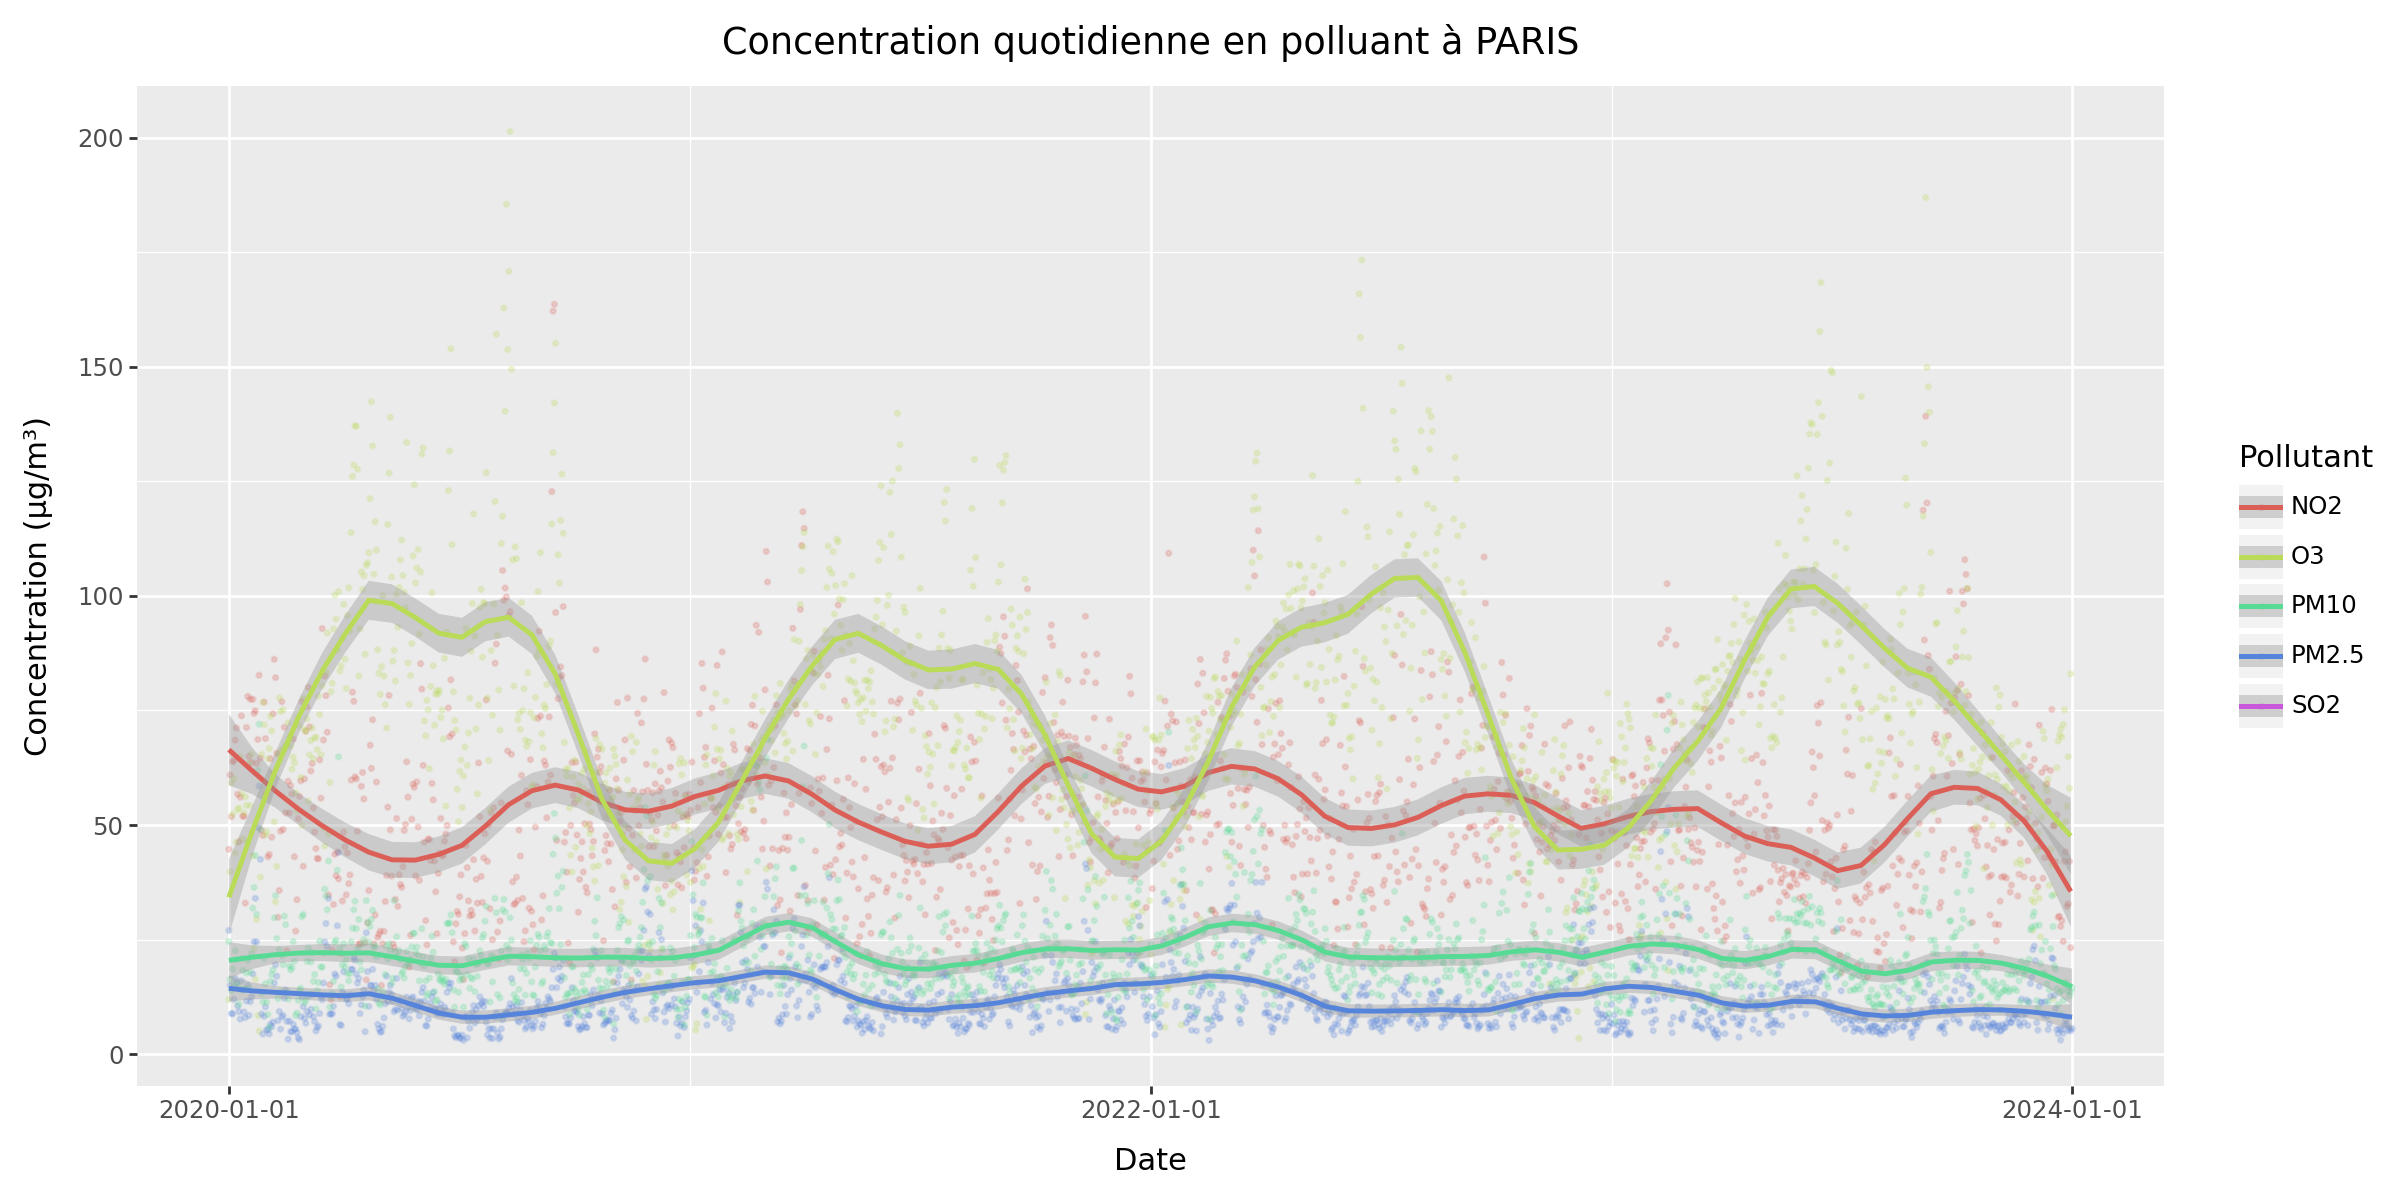

In [50]:
data = Y_t[(Y_t['nom_m'] == 'PARIS')]
# Si on veut visualiser la log-concentration, on peut utiliser la commande suivante:
#data[['NO2', 'O3', 'PM2.5', 'PM10', 'SO2']] = np.log(data[['NO2', 'O3', 'PM2.5', 'PM10', 'SO2']])
plot_pollutants_ggplot(data)

c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 51 rows containing missing values.


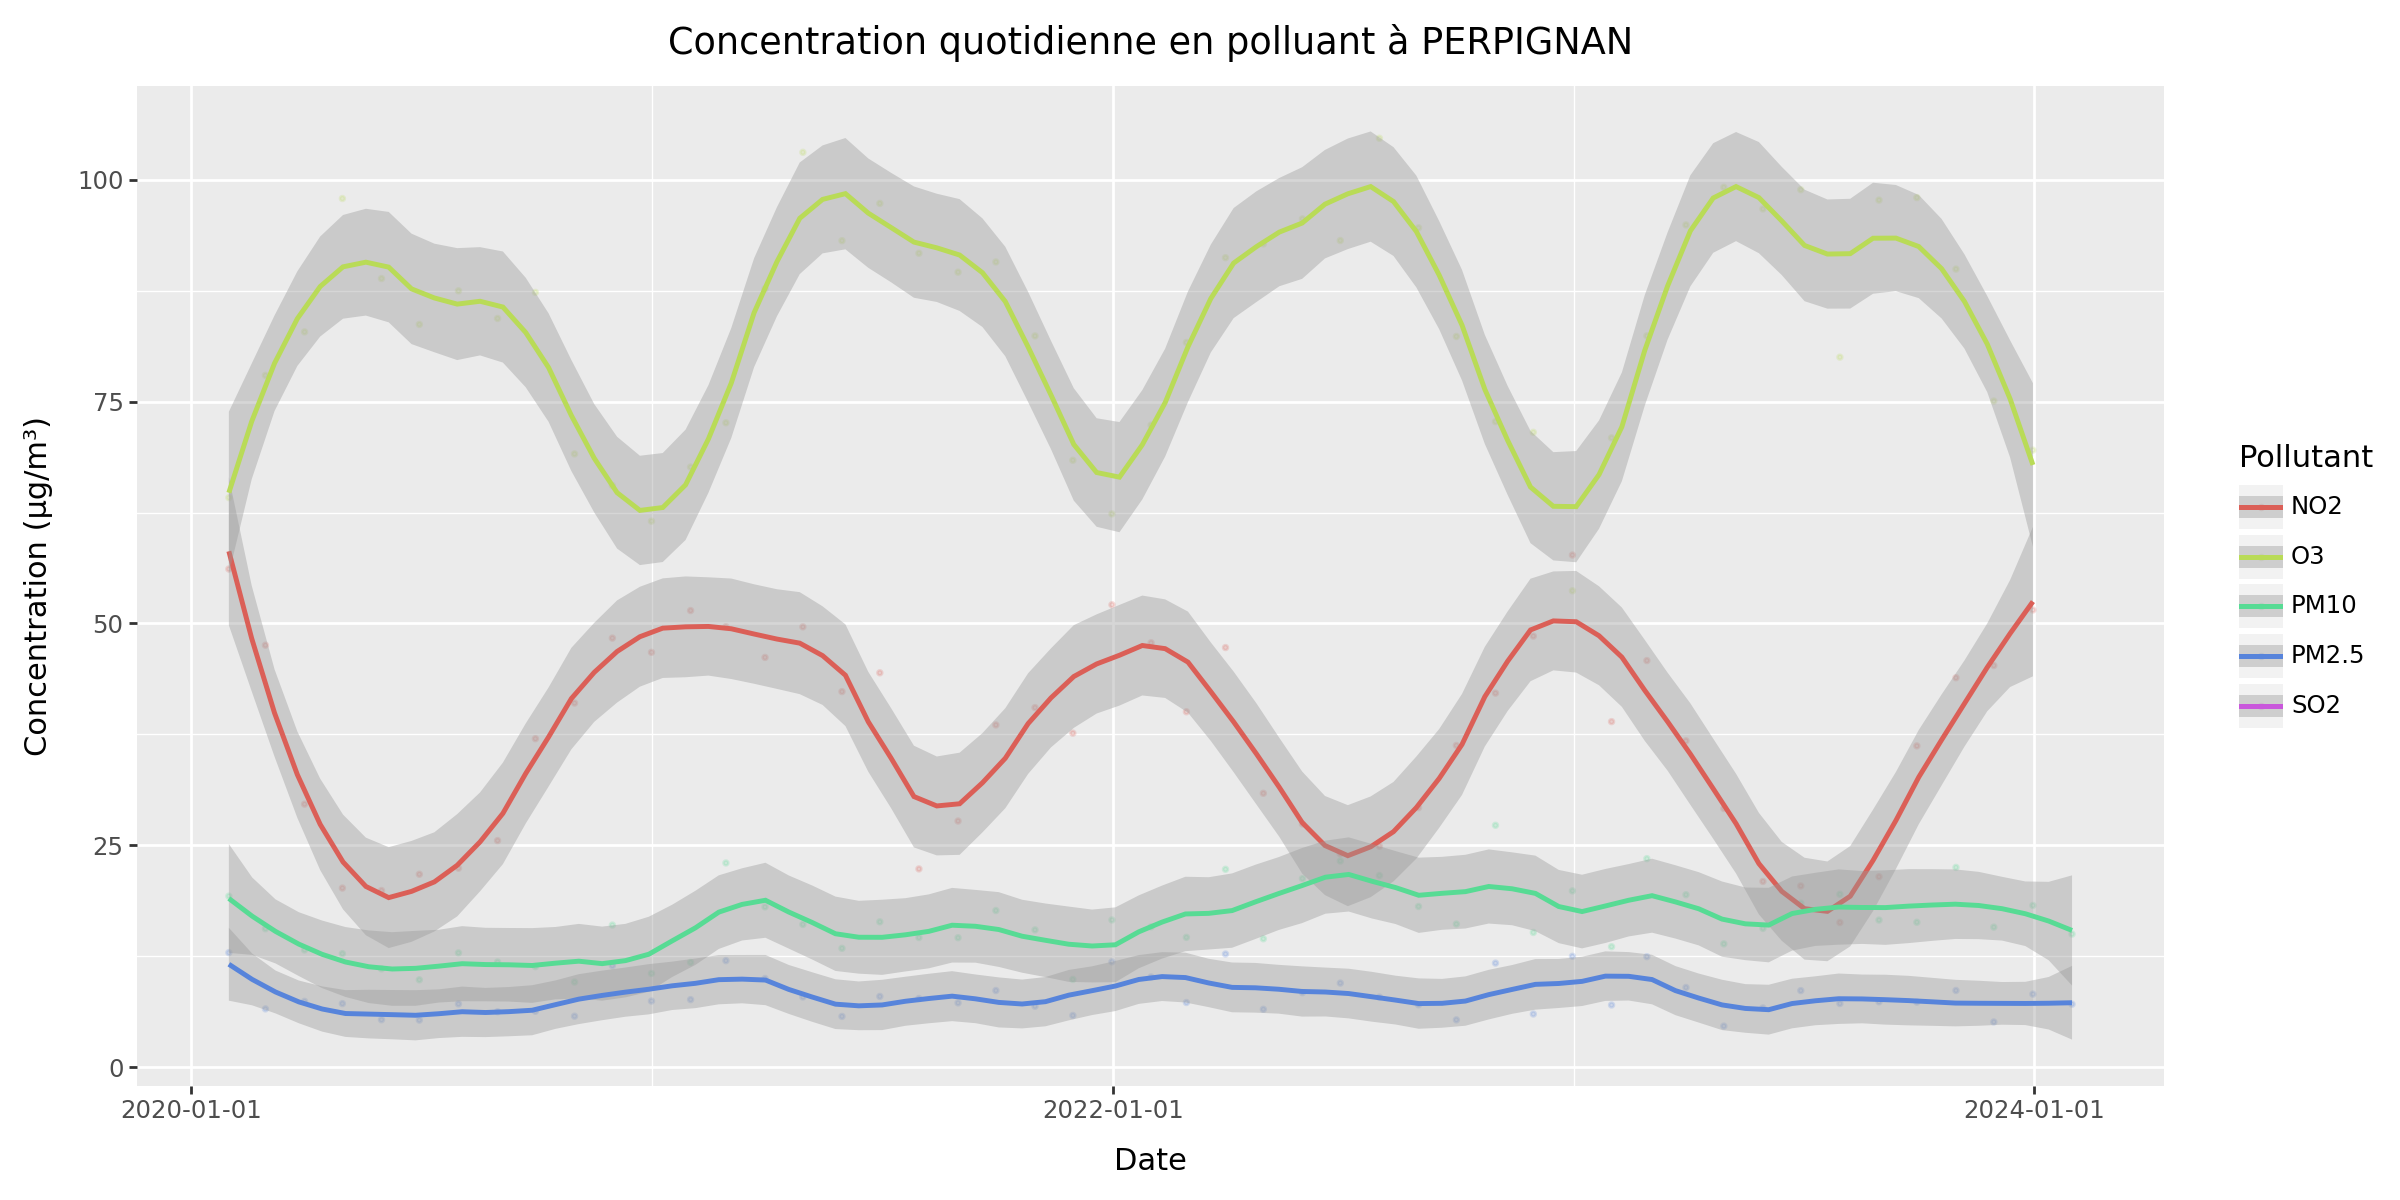

In [77]:

ville = 'PERPIGNAN'
data = Y_t[(Y_t['nom_m'] == ville)]
data.set_index('date', inplace=True)
monthly_data = data.resample('ME').mean(numeric_only=True)
monthly_data.reset_index(inplace=True)
# Si on veut visualiser la log-concentration, on peut utiliser la commande suivante:
#data[['NO2', 'O3', 'PM2.5', 'PM10', 'SO2']] = np.log(data[['NO2', 'O3', 'PM2.5', 'PM10', 'SO2']])
#plot_pollutants_ggplot(monthly_data)
monthly_data['nom_m'] = ville
plot_pollutants_ggplot(monthly_data, smoothing=0.2)

--> Observation

In [ ]:
# On regroupe par donées mensuells
ville = 'PERPIGNAN'
data = Y_t[(Y_t['nom_m'] == ville)]
data.set_index('date', inplace=True)
monthly_data = data.resample('ME').mean(numeric_only=True)
monthly_data.reset_index(inplace=True)
# Exemple : Chargement des données environnementales
# Remplacez cela par votre dataset réel
data = monthly_data

data.set_index('date', inplace=True)

# Définir la fréquence journalière
data.index.freq = 'M'

# Vérifiez votre colonne cible (par ex., 'NO2')
target_variable = 'NO2'

# Diviser les données en train/test si nécessaire
train = data[target_variable].loc[:'2022-12-31']

test = data[target_variable].loc['2023-01-01':]
'''
# Configurer et ajuster le modèle SARIMAX (saisonnier)
model = sm.tsa.statespace.SARIMAX(train, 
                order=(0, 2, 1),  # p, d, q
                seasonal_order=(1, 0, 0, 12),  # P, D, Q, S (S = saisonnalité annuelle pour les données journalières)
                enforce_stationarity=False, 
                enforce_invertibility=False)
'''
# Modèle non saisonnier
model = sm.tsa.statespace.SARIMAX(train, 
                order=(2, 1, 3),  # p, d, q
                enforce_stationarity=False, 
                enforce_invertibility=False)

results = model.fit(disp=False)

# Résumé du modèle
print(results.summary())


date
2020-01-31    56.135484
2020-02-29    47.548276
2020-03-31    29.637097
2020-04-30    20.185000
2020-05-31    19.909677
2020-06-30    21.740000
2020-07-31    22.420968
2020-08-31    25.533871
2020-09-30    37.016667
2020-10-31    41.029032
2020-11-30    48.351667
2020-12-31    46.745161
2021-01-31    51.452688
2021-02-28    49.633333
2021-03-31    46.171505
2021-04-30    49.617222
2021-05-31    42.322581
2021-06-30    44.439444
2021-07-31    22.341935
2021-08-31    27.738710
2021-09-30    38.563333
2021-10-31    40.519355
2021-11-30    37.640000
2021-12-31    52.106452
2022-01-31    47.822581
2022-02-28    40.050000
2022-03-31    47.283871
2022-04-30    30.863333
2022-05-31    27.400000
2022-06-30    24.045833
2022-07-31    24.893333
2022-08-31    29.238710
2022-09-30    36.255172
2022-10-31    42.148387
2022-11-30    48.573333
2022-12-31    57.706452
Freq: ME, Name: NO2, dtype: float64

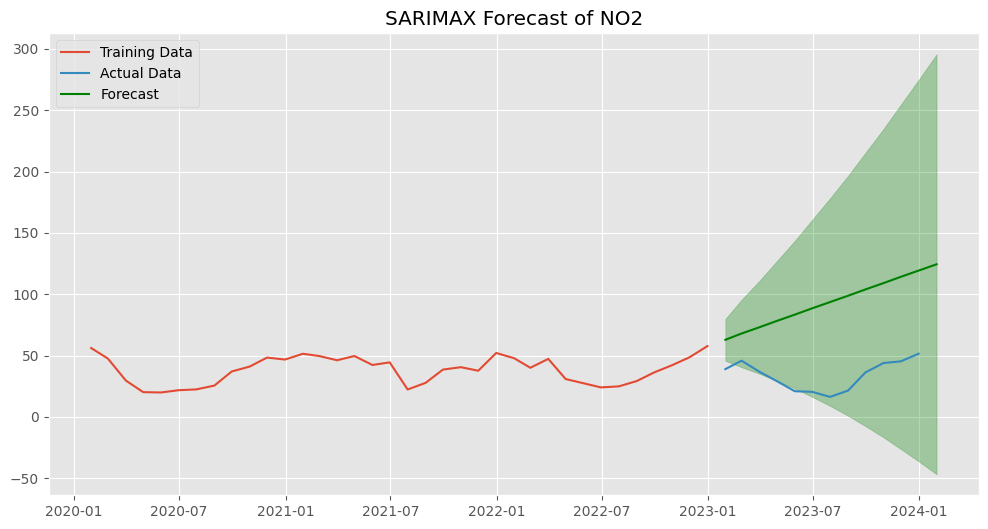

In [98]:
# Faire des prédictions
forecast = results.get_forecast(steps=len(test))
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Data')
plt.plot(forecast.predicted_mean, label='Forecast', color='green')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='green', alpha=0.3)
plt.legend()
plt.title(f'SARIMAX Forecast of {target_variable}')
plt.show()



In [102]:
# ON va essayer de voir quel modèle est le plus efficae (minimisation de AIC)
p = 6
q = 6
d = 3
print(eval_model(train,P = p,Q = q,D = d))
#print(select_model(train,P = p,Q = q,D = d))
#Le modèle réusltant pour Perpignan (asn compter la partie exogène X_t est (0,2,1))
# Nous n'avons pas la capacité computationnelles de produire une modèle saisonnier


          AIC Model
0  263.865157   100
1  252.658259   213
2  250.274576   021


In [177]:
# On va maintenant ajouter les données exogènes (sur X_t):
# On regroupe par donées mensuells
'''
ville = 'PERPIGNAN'
data = Y_t[(Y_t['nom_m'] == ville)]
data.set_index('date', inplace=True)
monthly_data = data.resample('ME').mean(numeric_only=True)
monthly_data.reset_index(inplace=True)
# Exemple : Chargement des données environnementales
'''
def arima_mensuel(df, ville):
    '''Une fonction qui transforme les données quotidiennes en données mensuelles, utilisatble pour ARIMA
        ville doit être entré en MAJUSCULES entre guillemets, exemple : vers_mensuel(Y_t, 'PERPIGNAN')
    '''
    data = df[df['nom_m']==ville]
    data.set_index('date', inplace = True)
    data_mensuel = data.resample('ME').mean(numeric_only=True)
    data_mensuel.reset_index(inplace=True)
    data_mensuel.index.freq = 'M'
    data_mensuel.set_index('date', inplace=True)
    return data_mensuel

target_variable = 'NO2'
exog_variables = ['pression_niveau_mer_Pa',
    'var_pression_3h_Pa',
    'direction_vent_moyen_10mn_deg',
    'vitesse_vent_moyen_10mn_m/s',
    'temperature_K',
    'humidite_%',
    'visibilite_horizontale_m',
    'precipitations_24h_mm'
    ]

exog_data =arima_mensuel(X_t, 'PERPIGNAN').loc[:, exog_variables].dropna() 
exog = sm.add_constant(exog_data)
endog = arima_mensuel(Y_t, 'PERPIGNAN').loc[exog_data.index,target_variable]
# Modèle non saisonnier
model = sm.tsa.statespace.SARIMAX(endog, exog,
                order=(1, 1, 0),  # p, d, q
                enforce_stationarity=False, 
                enforce_invertibility=False)

results = model.fit(disp=False)

# Résumé du modèle
print(results.summary())



                               SARIMAX Results                                
Dep. Variable:                    NO2   No. Observations:                   48
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -142.761
Date:                Tue, 24 Dec 2024   AIC                            307.523
Time:                        12:38:56   BIC                            327.638
Sample:                    01-31-2020   HQIC                           315.058
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                         -6.508e-12         -0        inf      0.000   -6.51e-12   -6.51e-12
pression_niveau_mer_Pa            0.0021      0.003      0.691      0.490 

In [139]:
hyp_param = select_model_optimized(endog = endog,exog =  exog, P = 5, Q = 5, D = 3)
hyp_param

(1, 1, 0)

Automatisation de la démarche

In [ ]:
from statistics import mode
Y_t_sample = Y_t[(Y_t['population']>=10000)].sample(3)

target_variable = 'NO2'
exog_variables = ['pression_niveau_mer_Pa',
    'var_pression_3h_Pa',
    'direction_vent_moyen_10mn_deg',
    'vitesse_vent_moyen_10mn_m/s',
    'temperature_K',
    'humidite_%',
    'visibilite_horizontale_m',
    'precipitations_24h_mm'
    ]

exog_data =arima_mensuel(X_t, ville).loc[:, exog_variables].dropna() 
exog = sm.add_constant(exog_data)
endog = arima_mensuel(Y_t, ville).loc[exog_data.index,target_variable]

for ville in list(Y_t_sample['nom_m']):
    #Set pour gagner en vitesse d'exécution
    set_hyp_param = []

    #On calcule le modèle optimal pour l'échantillon de villes
    exog_data =arima_mensuel(X_t, ville).loc[:, exog_variables].dropna() 
    exog = sm.add_constant(exog_data)
    endog = arima_mensuel(Y_t, ville).loc[exog_data.index,target_variable]
    set_hyp_param.append(select_model_optimized(endog = endog,exog =  exog, P = 5, Q = 5, D = 3))
    result = mode(set_hyp_param)

result


(0, 0, 1)

In [191]:
hyper_parametres = (1,1,1)
ville = 'PERPIGNAN'
polluant = 'NO2'

def resultat_arimax(Y,X = None, polluant ='NO2', hyper_param =(1,0,1), ville = 'STRASBOURG'):
    '''
    Cette fonction calcule les coefficiens ARIMA sachant les paramètres du modèles donnés.
    Elle revoit un dataframe contenant les valeurs estimées du modèles (coefficients et p-valeurs)
    '''
    # On traite les données exogènes
    exog_data =arima_mensuel(X, ville).loc[:, exog_variables].dropna() 

    # On traite les données endogènes
    endog_data = arima_mensuel(Y, ville).loc[exog_data.index,polluant]

    # On aligne les indice de endog et exog
    common_index = exog_data.index.intersection(endog_data.index)
    exog = sm.add_constant(exog_data.loc[common_index])
    endog = endog_data.loc[common_index, polluant]    
    endog = arima_mensuel(Y, ville).loc[exog_data.index,polluant]
    # Modèle non saisonnier
    model = sm.tsa.statespace.SARIMAX(endog, exog,
                order=hyper_param,  # p, d, q
                enforce_stationarity=False, 
                enforce_invertibility=False)

    results = model.fit(disp=False)
    return pd.DataFrame({
        'nom_m':ville, 
        'polluant':polluant,
        'coefficiens' : results.params,
        'p-valeurs' : results.pvalues
        })

resultat_arimax(Y_t,X_t,polluant=polluant,hyper_param=hyper_parametres,ville = ville)

def get_hyper_param_liste(Y,X):
    '''
    Cette fonction permet d'obtenir les paramètres optimaux pour la sélection du modèle arima pour chaque polluant
    Dans l'ordre: 'NO2','O3','PM2.5','PM10'.
    '''
    hyper_param_liste = []
    return hyper_param_liste

def arima_tout_polluants(Y,X, hyper_param_liste, ville):
    '''
    Cette fonction renvoie un dataframe contenant les résultat de l'estimation ARIMAX pour les paramètres spécifiés du modèle
    L'argument 'hyper_param_list' est une liste contenant les tuples correspondant aux hyperparamètres optimaux pour chaques polluant 
    (dans l'ordre : 'NO2','O3','PM2.5','PM10').
    '''
    polluant = ['NO2','O3','PM2.5','PM10']
    liste_arima_resultats = [
        resultat_arimax(Y,X,polluant=polluant[i], hyper_param = hyper_param_liste[i], ville = ville)
        for i in range(len(hyper_param_liste))
    ]
    output = pd.concat(liste_arima_resultats)
    return output
#Cette fonction fonctionne bien

def modelisation_arima(Y,X, hyper_param_liste):
    '''
    Cette fonction calcule les coefficients et p-valeurs pour chaque les villes du jeu dont la population est supérieure à pop_min (int)
    Elle renvoie le résultat sous forme de dataframe
    '''
    
    liste_arima_resultat_ville = [arima_tout_polluants( Y,X,hyper_param_liste,ville) for ville in list(Y['nom_m'])]
    output = pd.concat(liste_arima_resultat_ville)
    return output


modelisation_arima(Y_t_sample,X_t,[(1,0,1),(1,0,1),(1,0,1),(1,0,1)])


IndexingError: Too many indexers